In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm
from scipy import interpolate

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Using TensorFlow backend.
2022-08-23 01:00:35.897411: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 01:00:35.897957: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
# !pip install tensorflow

In [ ]:
# conda install scikit-learn

In [ ]:
## 1. 데이터 불러오기, 공통 전처리
raw_data = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/rawdata.csv')

###유량 처리
유량 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/잠수교_유량_수위_보간/청담대교_cuve_fit.csv', encoding='cp949')
유량 = 유량.iloc[:,[2,4,6,8]]
유량 = 유량.interpolate()
_raw_data = pd.concat((raw_data.drop(유량.columns,axis=1), 유량),axis=1)
raw_data = _raw_data

###유입량, 저수량 제거
raw_data_ = raw_data.drop(raw_data[['유입량','저수량','대곡교_강수량','진관교_강수량','송정동_강수량','잠수교_유량']], axis = 1)

###강화대교 조위 시간차
강화대교_조위 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/시간차/강화대교_조위 for 전체.csv', encoding='cp949')
raw_data__ = pd.concat((raw_data_.drop(강화대교_조위.columns,axis=1),강화대교_조위),axis=1)

###방류량 조위 시간차
방류량 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/시간차/방류량 for 전체.csv', encoding='cp949')
__raw_data = pd.concat((raw_data__.drop(방류량.columns,axis=1),방류량),axis=1)
raw_data___ = __raw_data.set_index('날짜',drop=True)

###보간 처리
보간처리 = raw_data___[['현재수위','공용량','방류량','강화대교_조위', '청담대교_유량', '한강대교_유량', '행주대교_유량', '청담대교_수위', '잠수교_수위', '한강대교_수위', '행주대교_수위']].interpolate(method = 'linear' , limit_direction = 'forward')
보간처리df = pd.concat([raw_data___.drop(보간처리.columns, axis = 1), 보간처리], axis=1)

input_y = 보간처리df[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = 보간처리df.drop(input_y.columns, axis = 1)


## 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

#train / test data 생성
idx = []
for i in range(12):
  idx.append(i*26496)

In [ ]:
for i in range(len(input_x.columns)):
    scaler = StandardScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    print(a)
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    print(tmp_x)
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)

[-0.59266223 -0.60574877 -0.61665422 ... -0.06920059 -0.06920059
 -0.06920059]
[[-0.59266223]
 [-0.60574877]
 [-0.61665422]
 ...
 [-0.06920059]
 [-0.06920059]
 [-0.06920059]]
[0.02695245 0.04767827 0.06275159 ... 0.61198579 0.61198579 0.61198579]
[[0.02695245]
 [0.04767827]
 [0.06275159]
 ...
 [0.61198579]
 [0.61198579]
 [0.61198579]]
[ 0.03043291  0.03007069  0.01168818 ... -0.25675084 -0.25666934
 -0.25717644]
[[ 0.03043291]
 [ 0.03007069]
 [ 0.01168818]
 ...
 [-0.25675084]
 [-0.25666934]
 [-0.25717644]]
[-0.8900623  -0.85546313 -0.80933089 ...  0.60923541  0.74186559
  0.87449577]
[[-0.8900623 ]
 [-0.85546313]
 [-0.80933089]
 ...
 [ 0.60923541]
 [ 0.74186559]
 [ 0.87449577]]
[-0.21181893 -0.19162195 -0.19672875 ... -0.26867744 -0.22168371
 -0.13287281]
[[-0.21181893]
 [-0.19162195]
 [-0.19672875]
 ...
 [-0.26867744]
 [-0.22168371]
 [-0.13287281]]
[ 0.09356893  0.09478911  0.09111405 ... -1.04902102 -1.17975463
 -1.19868922]
[[ 0.09356893]
 [ 0.09478911]
 [ 0.09111405]
 ...
 [-1.0490

In [ ]:
input_x

,현재수위,공용량,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량
날짜,,,,,,,
2012-05-01 00:00,24.800,24.93,575.70,193.0,469.05,729.80,540.18
2012-05-01 00:10,24.794,25.15,575.30,199.0,498.00,731.48,540.18
2012-05-01 00:20,24.789,25.31,555.00,207.0,490.68,726.42,540.18
2012-05-01 00:30,24.789,25.31,575.70,215.0,476.21,726.42,552.17
2012-05-01 00:40,24.789,25.31,575.40,226.0,476.21,707.17,564.29
...,...,...,...,...,...,...,...
2022-07-18 23:10,25.040,31.14,258.67,407.0,319.84,-456.41,974.40
2022-07-18 23:20,25.040,31.14,258.58,431.0,314.01,-717.30,1006.88
2022-07-18 23:30,25.040,31.14,258.56,453.0,387.55,-843.37,1039.90


In [ ]:
input_y

,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,
2012-05-01 00:00,310.7,300.2,290.0,275.3
2012-05-01 00:10,314.7,300.2,290.0,275.3
2012-05-01 00:20,313.7,301.2,290.0,275.3
2012-05-01 00:30,311.7,301.2,290.0,276.3
2012-05-01 00:40,311.7,301.2,291.0,277.3
...,...,...,...,...
2022-07-18 23:10,0.0,0.0,0.0,0.0
2022-07-18 23:20,0.0,0.0,0.0,0.0
2022-07-18 23:30,0.0,0.0,0.0,0.0


In [ ]:
input_x_regular

,현재수위,공용량,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량
날짜,,,,,,,
2012-05-01 00:00,-0.592662,0.026952,0.030433,-0.890062,-0.211819,0.093569,-0.361714
2012-05-01 00:10,-0.605749,0.047678,0.030071,-0.855463,-0.191622,0.094789,-0.361714
2012-05-01 00:20,-0.616654,0.062752,0.011688,-0.809331,-0.196729,0.091114,-0.361714
2012-05-01 00:30,-0.616654,0.062752,0.030433,-0.763199,-0.206824,0.091114,-0.353319
2012-05-01 00:40,-0.616654,0.062752,0.030161,-0.699767,-0.206824,0.077133,-0.344834
...,...,...,...,...,...,...,...
2022-07-18 23:10,-0.069201,0.611986,-0.256651,0.343975,-0.315915,-0.767973,-0.057697
2022-07-18 23:20,-0.069201,0.611986,-0.256733,0.482372,-0.319983,-0.957457,-0.034957
2022-07-18 23:30,-0.069201,0.611986,-0.256751,0.609235,-0.268677,-1.049021,-0.011838


In [ ]:
input_regular

,현재수위,공용량,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,,,
2012-05-01 00:00,-0.592662,0.026952,0.030433,-0.890062,-0.211819,0.093569,-0.361714,310.7,300.2,290.0,275.3
2012-05-01 00:10,-0.605749,0.047678,0.030071,-0.855463,-0.191622,0.094789,-0.361714,314.7,300.2,290.0,275.3
2012-05-01 00:20,-0.616654,0.062752,0.011688,-0.809331,-0.196729,0.091114,-0.361714,313.7,301.2,290.0,275.3
2012-05-01 00:30,-0.616654,0.062752,0.030433,-0.763199,-0.206824,0.091114,-0.353319,311.7,301.2,290.0,276.3
2012-05-01 00:40,-0.616654,0.062752,0.030161,-0.699767,-0.206824,0.077133,-0.344834,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10,-0.069201,0.611986,-0.256651,0.343975,-0.315915,-0.767973,-0.057697,0.0,0.0,0.0,0.0
2022-07-18 23:20,-0.069201,0.611986,-0.256733,0.482372,-0.319983,-0.957457,-0.034957,0.0,0.0,0.0,0.0
2022-07-18 23:30,-0.069201,0.611986,-0.256751,0.609235,-0.268677,-1.049021,-0.011838,0.0,0.0,0.0,0.0


In [ ]:
start = time.time()

y_predict = []

ytest_list = sorted(glob("/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/submission 임시/*.csv"))

ytest = []

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949')
  ytest.append(np.array(tmp.iloc[:,1])*100)

In [ ]:
ytest

[array([279., 281., 284., ..., 299., 309., 326.]),
 array([276., 277., 277., ..., 307., 311., 314.]),
 array([274., 274., 274., ..., 309., 314., 317.]),
 array([269., 267., 264., ..., 310., 312., 313.])]

In [ ]:
xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

In [ ]:
xdata_idx

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
idx

[0,
 26496,
 52992,
 79488,
 105984,
 132480,
 158976,
 185472,
 211968,
 238464,
 264960,
 291456]

In [ ]:
w =  432 #window size

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w+1):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w-1,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

xdata_ = np.array(xdata)
ydata_ = np.array(ydata)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
#ytest = ydata_[-6912:]

100%|███████████████████████████████████████████| 11/11 [01:09<00:00,  6.32s/it]


In [ ]:
print(len(xdata), len(xdata[0]), len(xdata[1]), len(xdata[0][0]))

271595 432 432 7


In [ ]:
xdata

[array([[-0.59266223,  0.02695245,  0.03043291, ..., -0.21181893,
          0.09356893, -0.36171407],
        [-0.60574877,  0.04767827,  0.03007069, ..., -0.19162195,
          0.09478911, -0.36171407],
        [-0.61665422,  0.06275159,  0.01168818, ..., -0.19672875,
          0.09111405, -0.36171407],
        ...,
        [-0.07138168, -0.75780242, -0.1744008 , ..., -0.25958706,
         -0.21464281, -0.37001079],
        [-0.07138168, -0.75780242, -0.16914866, ..., -0.25034319,
         -0.20854917, -0.37821648],
        [-0.07138168, -0.75780242, -0.17566856, ..., -0.25498257,
         -0.19303545, -0.38632415]]),
 array([[-0.60574877,  0.04767827,  0.03007069, ..., -0.19162195,
          0.09478911, -0.36171407],
        [-0.61665422,  0.06275159,  0.01168818, ..., -0.19672875,
          0.09111405, -0.36171407],
        [-0.61665422,  0.06275159,  0.03043291, ..., -0.20682376,
          0.09111405, -0.35331934],
        ...,
        [-0.07138168, -0.75780242, -0.16914866, ..., -

In [ ]:
len(ydata)

271595

In [ ]:
ydata_[-6912:]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:

    
# 모델링 및 모델 학습

if 'model' in locals(): 
    del model 
if 'history' in locals():
    del history


## L1, L2 Regularizers
#regs = [tf.keras.regularizers.L1(0.1), tf.keras.regularizers.L1(0.01), tf.keras.regularizers.L1(0.001), tf.keras.regularizers.L1(0.0001),
#        tf.keras.regularizers.L2(0.1), tf.keras.regularizers.L2(0.01), tf.keras.regularizers.L2(0.001), tf.keras.regularizers.L2(0.0001)]
#for reg in regs:
    
#He_normal
He_normal = keras.initializers.he_normal(seed=None)

model = Sequential()
model.add(Conv1D(filters = 8, input_shape = (w, len(input_regular.columns)-4), kernel_size = 2, padding='causal', dilation_rate=2, kernel_initializer = He_normal))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))  #0.2~0.5  0.8까지

model.add(Conv1D(filters = 16, kernel_size = 2, padding='causal', dilation_rate=4, kernel_initializer = He_normal))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(AveragePooling1D(pool_size=2))

model.add(Conv1D(filters = 32, kernel_size = 2, padding='causal', dilation_rate=8, kernel_initializer = He_normal))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv1D(filters = 32, kernel_size = 1))

model.add(Flatten())   #model.add(GlobalAveragePooling1D(pool_size=2))

model.add(Dense(30, kernel_initializer = He_normal))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(4))


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

opt = tf.keras.optimizers.Adam(lr=0.005) #기본값 0.001
model.compile(optimizer=opt, loss=root_mean_squared_error, metrics =["accuracy"])
model.summary()



callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5),
                keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                monitor='val_loss',
                                                save_best_only=True)]

history = model.fit(xtrain, ytrain, epochs=300, verbose=1, validation_split=0.2, callbacks=callbacks, batch_size = 3742) #batch size..?


keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

keras_model_best.evaluate(xtest,ytest)

y_predict.append(keras_model_best.predict(xtest))

print("time :", time.time() - start, "초")

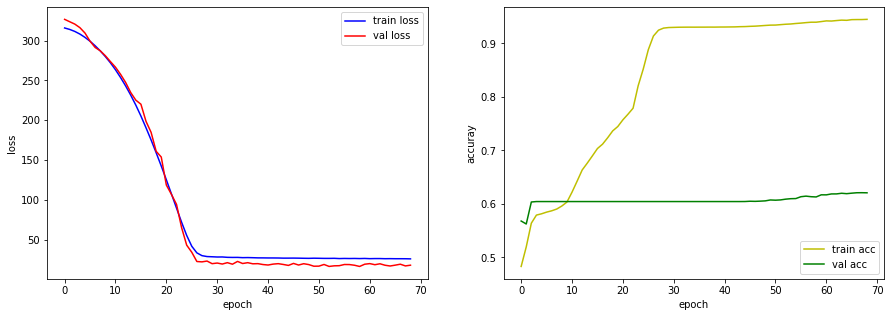

In [ ]:
#학습 과정 표시하기
%matplotlib inline
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['accuracy'], 'y', label='train acc')
loss_ax[1].plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('accuray')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

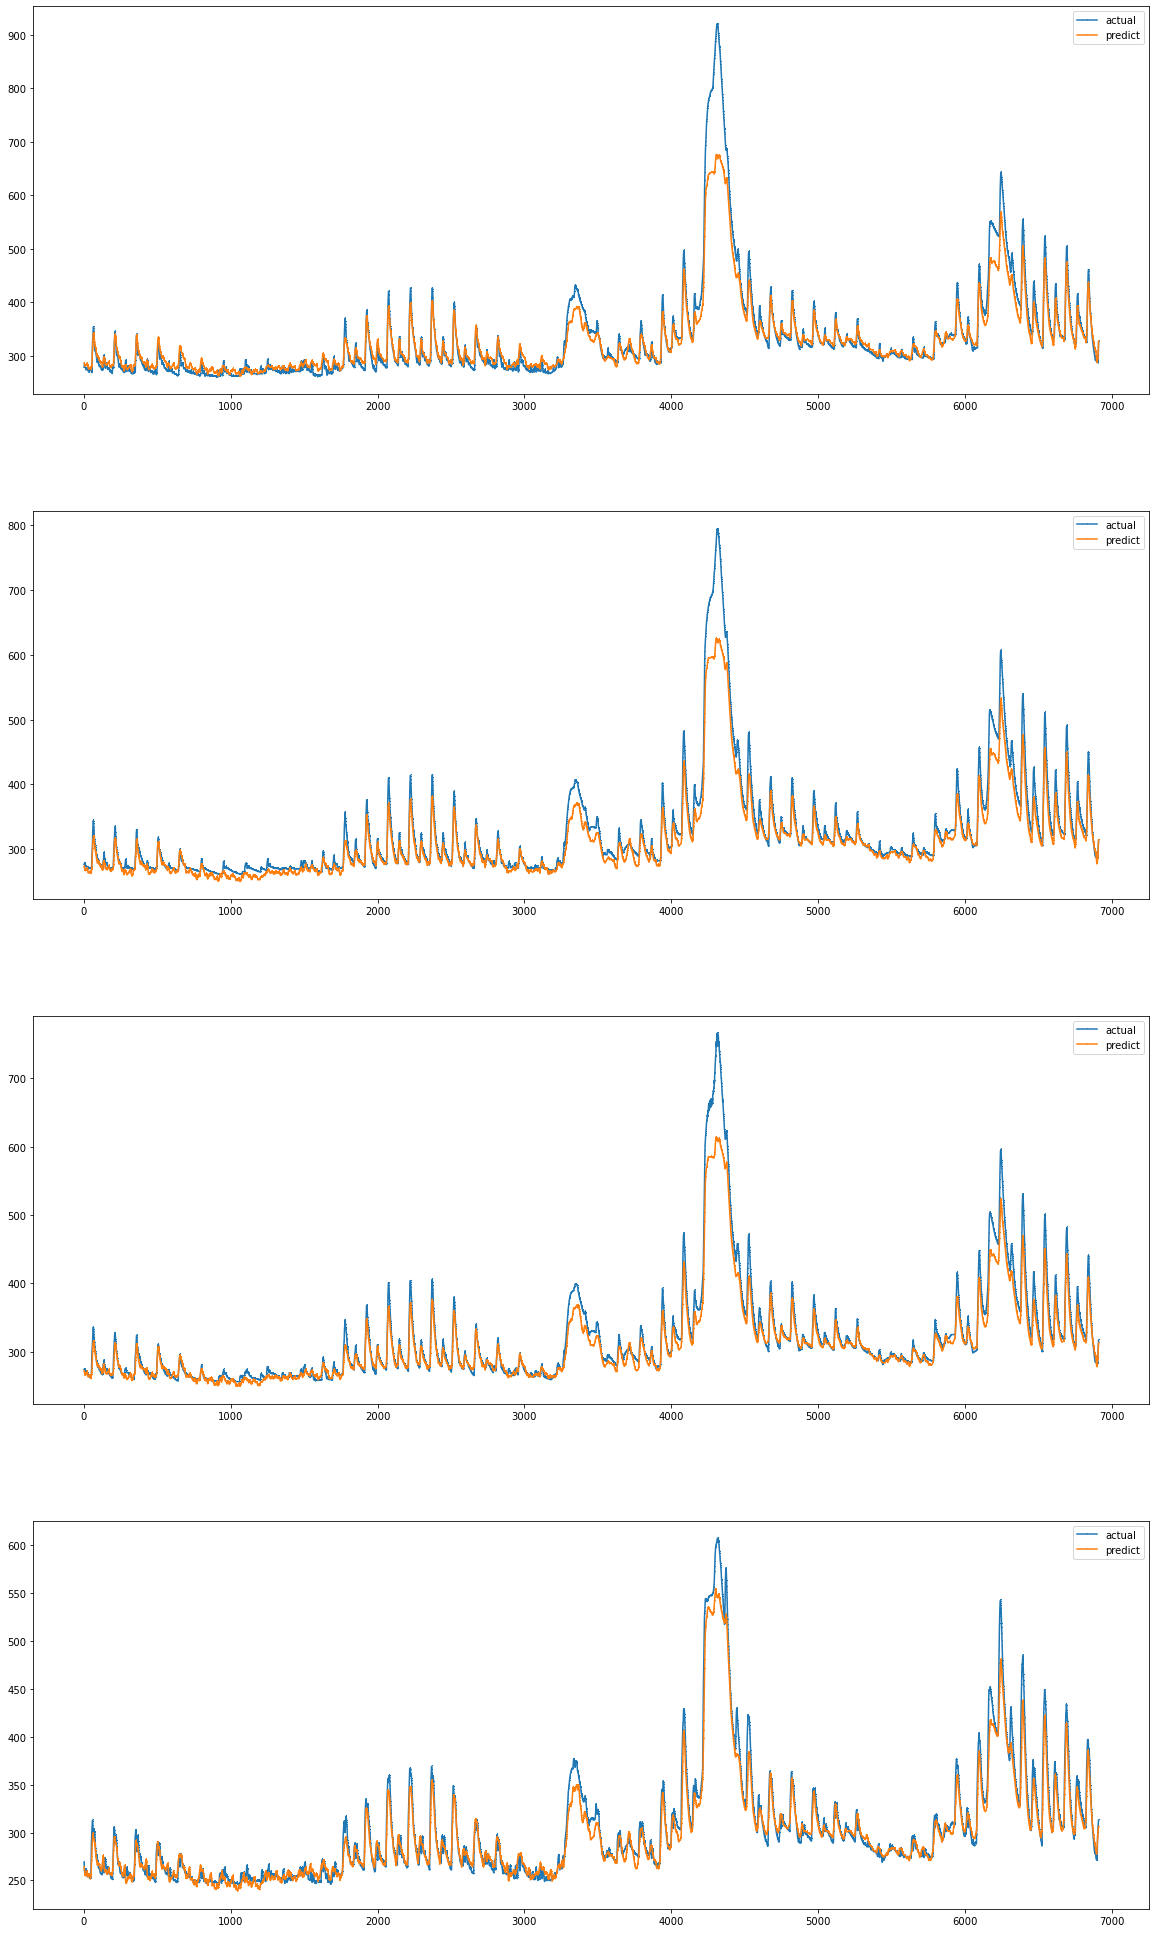

In [ ]:
tl_predict = np.array(y_predict).reshape(6912,4).T

#결과 시각화
f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

In [ ]:
#점수 채점하기
score = []
for i in range(4):
    print(root_mean_squared_error(ytest[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

tf.Tensor(29.21158166168749, shape=(), dtype=float64)
tf.Tensor(22.774231468036465, shape=(), dtype=float64)
tf.Tensor(20.059763348703964, shape=(), dtype=float64)
tf.Tensor(12.42360331560781, shape=(), dtype=float64)
최종점수:  21.11729494850893


In [ ]:
#제출 파일 생성

sample_submission = pd.read_csv("C:/Users/sjkan/Desktop/연세/YBIGTA/22 여름방학/신입기수프로젝트/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("0820 conv1d.csv", index = False)

In [ ]:
#결과: 12.9208469187